# 3. Wavelet Coefficient Maps Generation Notebook

### This notebook is designed to generate wavelet coefficient maps for each frequency total maps. 


### 3.1 We first create the directory structure to store the outputs.

In [ ]:
# !pip install s2fft --upgrade 
# !pip install conan 
# !pip isntall pyssht
# !pip install healpy --upgrade
# !pip install matplotlib --upgrade
# !pip install numpy --upgrade
# !pip install jax --upgrade

In [93]:
import os

def check_and_create_directories():
    """
    Checks for the existence of a nested directory structure and creates any missing directories.
    Prints a message whether the directory is created or already exists.

    The structure checked is:
    - wavelet_transform
      - maps
      - wavelets
        - wav_MW_maps
        - scal_coeffs
    """

    # Define the root directory and subdirectories
    root_dir = "wavelet_transform"
    sub_dirs = ["maps", "wavelets"]
    wavelet_sub_dirs = ["wav_MW_maps", "scal_coeffs"]

    # Check if root directory exists, create if not
    if not os.path.exists(root_dir):
        os.mkdir(root_dir)
        print(f"Created directory: {root_dir}")
    else:
        print(f"Directory already exists: {root_dir}")
    
    # Iterate over and create subdirectories in the root directory
    for sub_dir in sub_dirs:
        dir_path = os.path.join(root_dir, sub_dir)
        if not os.path.exists(dir_path):
            os.mkdir(dir_path)
            print(f"Created directory: {dir_path}")
        else:
            print(f"Directory already exists: {dir_path}")
        
        # For the 'wavelets' directory, check and create nested subdirectories
        if sub_dir == "wavelets":
            for wavelet_sub_dir in wavelet_sub_dirs:
                nested_dir_path = os.path.join(dir_path, wavelet_sub_dir)
                if not os.path.exists(nested_dir_path):
                    os.mkdir(nested_dir_path)
                    print(f"Created directory: {nested_dir_path}")
                else:
                    print(f"Directory already exists: {nested_dir_path}")

# Run the function to check and create directories as needed
check_and_create_directories()


Directory already exists: wavelet_transform
Directory already exists: wavelet_transform/maps
Directory already exists: wavelet_transform/wavelets
Directory already exists: wavelet_transform/wavelets/wav_MW_maps
Directory already exists: wavelet_transform/wavelets/scal_coeffs


### 3.2 Functions used to generate wavelet coefficient maps.

wavelet_transform: Applies the wavelet transform to the input map using specified parameters (L_max, N_directions).
save_wavelet_scaling_coeffs: Saves the computed wavelet and scaling coefficients to .npy files.
load_wavelet_scaling_coeffs: Loads previously saved wavelet and scaling coefficients from files.
generate_wavelet_coeffs: The main function that reads a CMB map, converts it to spherical harmonic coefficients, applies the wavelet transform, saves the results, and visualizes the wavelet coefficient maps.

In [94]:
import jax
jax.config.update("jax_enable_x64", True)
import s2fft
import healpy as hp
import numpy as np
import s2wav
import s2wav.filters as filters
import matplotlib.pyplot as plt
import os
import skyclean as sc

def mw_alm_2_hp_alm(MW_alm, lmax):
    '''MW_alm: 2D array of shape (Lmax, 2*Lmax-1) (MW sampling, McEwen & Wiaux)
    '''
    # Initialize the 1D hp_alm array with the appropriate size
    hp_alm = np.zeros(hp.Alm.getsize(lmax), dtype=np.complex128)
        
    for l in range(lmax + 1):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(lmax, l, abs(m))
            if m < 0:
                hp_alm[index] = (-1)**m * np.conj(MW_alm[l, lmax + m])
            else:
                hp_alm[index] = MW_alm[l, lmax + m]

    return hp_alm


def hp_alm_2_mw_alm(hp_alm, L_max):
    """
    Converts spherical harmonics (alm) to a matrix representation for use in MW sampling.

    This function takes 1D Healpix spherical harmonics coefficients (alm) and converts them into a matrix form 
    that is in (MW sampling, McEwen & Wiaux) sampling. The matrix form is complex-valued 
    and indexed by multipole moment and azimuthal index.

    Parameters:
        hp_alm (numpy.ndarray): The input healpix spherical harmonics coefficients (alm).
        L_max (int): The maximum multipole moment to be represented in the output matrix.
    
    Note: # L_max = 4 | l = 0,1,2,3 , true lmax is L_max-1 = 3 | m = -3...0...(L_max-1 = 3)| number of m = 2(L_max-1)+1 = 2L_max-1

    Returns:
        MW_alm (numpy.ndarray): 2D array of shape (Lmax, 2*Lmax-1) MW spherical harmonics coefficients 
    """

    MW_alm = np.zeros((L_max, 2 * L_max - 1), dtype=np.complex128)

    for l in range(L_max):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(L_max - 1, l, abs(m))
            if m < 0:
                MW_alm[l, L_max + m - 1] = (-1) ** m * np.conj(hp_alm[index])
            else:
                MW_alm[l, L_max + m - 1] = hp_alm[index]

    return MW_alm

def visualize_MW_Pix_map(MW_Pix_Map, title, coord=["G"], unit = r"K", is_MW_alm = False):
    """
    Processes a MW pixel wavelet coefficient map and visualizes it using HEALPix mollview.

    Parameters:
        MW_Pix_Map (numpy array): Array representing the wavelet coefficient map.
        title (str): Title for the visualization plot.

    Returns:
        Only Displays a mollview map.
    """
    if is_MW_alm:
        original_map_alm = MW_Pix_Map
        L_max = original_map_alm.shape[0]
    else:
        # The newly generated wavelet coefficient map is in three dimensions
        if len(MW_Pix_Map.shape) == 3:
            L_max = MW_Pix_Map.shape[1]
            print(MW_Pix_Map.shape)
        else:
            L_max = MW_Pix_Map.shape[0]
        original_map_alm = s2fft.forward(MW_Pix_Map, L=L_max)
        print("ME alm shape:", original_map_alm.shape)


    original_map_hp_alm = mw_alm_2_hp_alm(original_map_alm, L_max-1)
    original_hp_map = hp.alm2map(original_map_hp_alm, nside=(L_max - 1)//2)

    hp.mollview(
        original_hp_map,
        coord=coord,
        title=title,
        unit=unit,
        # min=min, max=max,  # Uncomment and adjust these as necessary for better visualization contrast
    )
    # plt.figure(dpi=1200)
    plt.show()


def wavelet_transform(mw_pix_map, L_max, N_directions):
    filter = filters.filters_directional_vectorised(L_max, N_directions)
    MW_Pix_wavelet_coeffs, MW_Pix_scaling_coeffs = s2wav.analysis(mw_pix_map, N=N_directions, L=L_max, filters=filter, reality=False)
    return MW_Pix_wavelet_coeffs, MW_Pix_scaling_coeffs

def save_wavelet_scaling_coeffs(wavelet_coeffs, scaling_coeffs, frequency, realization, component,
                                wav_template="wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_{component}_F{frequency}_S{scale}_R{realization:04d}.npy",
                                scal_template="wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_{component}_F{frequency}_R{realization:04d}.npy"):

    for scale, wav in enumerate(wavelet_coeffs):
        np_wav = np.array(wav)
        np.save(wav_template.format(component=component, frequency=frequency, scale=scale, realization=realization), np_wav)

    np_scaling = np.array(scaling_coeffs)
    np.save(scal_template.format(component=component, frequency=frequency, realization=realization), np_scaling)



def load_wavelet_scaling_coeffs(frequency, num_wavelets, realization, component,
                                wav_template="wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_{component}_F{frequency}_S{scale}_R{realization:04d}.npy",
                                scal_template="wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_{component}_F{frequency}_R{realization:04d}.npy"):

    wavelet_coeffs = [np.real(np.load(wav_template.format(component=component, frequency=frequency, scale=scale, realization=realization)))
                      for scale in range(num_wavelets)]
    scaling_coeffs = np.real(np.load(scal_template.format(component=component, frequency=frequency, realization=realization)))
    return wavelet_coeffs, scaling_coeffs


def generate_wavelet_coeffs(CMB_map_path, frequency, L_max, N_directions, realization, component):
    # Step 1: Read the Healpix map
    healpix_map = hp.read_map(CMB_map_path)

    # Step 2: Convert Healpix map to spherical harmonic coefficients
    hp_alm = hp.map2alm(healpix_map, L_max)

    # Step 3: Convert spherical harmonics to MW coefficients
    mw_alm = hp_alm_2_mw_alm(hp_alm, L_max)

    # Step 4: Transform MW coefficients back to a map (optional, based on use case)
    original_MW_Map = s2fft.inverse(mw_alm, L_max)
    # np.save(f'wavelet_transform/maps/Original_MW_Pix_map_F{frequency}_R{realization:04d}.npy', original_MW_Map)

    # Step 5: Apply wavelet transform to the MW map to get wavelet and scaling coefficients
    wavelet_coeffs, scaling_coeffs = wavelet_transform(original_MW_Map, L_max, N_directions)

    # Step 6: Save the wavelet and scaling coefficients
    save_wavelet_scaling_coeffs(wavelet_coeffs, scaling_coeffs, frequency, realization, component)

    # Step 7: Load the wavelet and scaling coefficients
    loaded_wavelet_coeffs, loaded_scaling_coeffs = load_wavelet_scaling_coeffs(frequency, len(wavelet_coeffs), realization, component)

    # Print shapes and graph for verification
    for scale in range(len(loaded_wavelet_coeffs)):
        print("wavelets shape", loaded_wavelet_coeffs[scale].shape)
        visualize_MW_Pix_map(loaded_wavelet_coeffs[scale], f"{component} Wavelet Coefficient Map at Scale {scale}")
    return loaded_wavelet_coeffs, loaded_scaling_coeffs, original_MW_Map


In [ ]:
# ======= FFP10 tSZ bandmaps → wavelet coeffs (new names, no old Csz names) =======
import os
import re
import glob
import requests
import healpy as hp
import numpy as np
from pathlib import Path

# ---------------------------------------------------------------------
# Settings
# ---------------------------------------------------------------------
STORE = Path("CMB_realizations")
STORE.mkdir(parents=True, exist_ok=True)

# FFP10 per-frequency tSZ (sky-in-bands) URLs, keyed by frequency
FFP10_TSZ_URLS = {
    "100": "http://pla.esac.esa.int/pla/aio/product-action?SIMULATED_MAP.FILE_ID=COM_SimMap_thermalsz-ffp10-skyinbands-100_2048_R3.00_full.fits",
    "143": "http://pla.esac.esa.int/pla/aio/product-action?SIMULATED_MAP.FILE_ID=COM_SimMap_thermalsz-ffp10-skyinbands-143_2048_R3.00_full.fits",
    "217": "http://pla.esac.esa.int/pla/aio/product-action?SIMULATED_MAP.FILE_ID=COM_SimMap_thermalsz-ffp10-skyinbands-217_2048_R3.00_full.fits",
    "353": "http://pla.esac.esa.int/pla/aio/product-action?SIMULATED_MAP.FILE_ID=COM_SimMap_thermalsz-ffp10-skyinbands-353_2048_R3.00_full.fits",
    "545": "http://pla.esac.esa.int/pla/aio/product-action?SIMULATED_MAP.FILE_ID=COM_SimMap_thermalsz-ffp10-skyinbands-545_2048_R3.00_full.fits",
    "857": "http://pla.esac.esa.int/pla/aio/product-action?SIMULATED_MAP.FILE_ID=COM_SimMap_thermalsz-ffp10-skyinbands-857_2048_R3.00_full.fits",
}

TIMEOUT = 90
PURGE_OLD_CSZ = True          # remove any old Csz-named files
CREATE_ALIAS_OLD_NAMES = True # keep a compat alias with the old name

# Wavelet / save config
COMPONENT = "tSZ"
L_MAX     = 32
N_DIRS    = 1
REALIZATION = "R0000"         # <-- change if you want a different tag
REALIZATION_INT = int(REALIZATION[1:]) if isinstance(REALIZATION, str) and REALIZATION.startswith("R") else int(REALIZATION)
 
# ---------------------------------------------------------------------
# Your helpers (from your earlier code) — with a small fix: lmax = L_max-1
# ---------------------------------------------------------------------
import s2fft
import s2wav
from s2wav import filters

def hp_alm_2_mw_alm(hp_alm, L_max):
    MW_alm = np.zeros((L_max, 2 * L_max - 1), dtype=np.complex128)
    for l in range(L_max):
        for m in range(-l, l + 1):
            index = hp.Alm.getidx(L_max - 1, l, abs(m))
            if m < 0:
                MW_alm[l, L_max + m - 1] = (-1) ** m * np.conj(hp_alm[index])
            else:
                MW_alm[l, L_max + m - 1] = hp_alm[index]
    return MW_alm

def wavelet_transform(mw_pix_map, L_max, N_directions):
    filt = filters.filters_directional_vectorised(L_max, N_directions)
    MW_Pix_wavelet_coeffs, MW_Pix_scaling_coeffs = s2wav.analysis(
        mw_pix_map, N=N_directions, L=L_max, filters=filt, reality=False
    )
    return MW_Pix_wavelet_coeffs, MW_Pix_scaling_coeffs

def save_wavelet_scaling_coeffs(wavelet_coeffs, scaling_coeffs, frequency, realization, component,
                                wav_template="wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_{component}_F{frequency}_S{scale}_R{realization:04d}.npy",
                                scal_template="wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_{component}_F{frequency}_R{realization:04d}.npy"):
    os.makedirs("wavelet_transform/wavelets/wav_MW_maps", exist_ok=True)
    os.makedirs("wavelet_transform/wavelets/scal_coeffs", exist_ok=True)
    for scale, wav in enumerate(wavelet_coeffs):
        np.save(wav_template.format(component=component, frequency=frequency, scale=scale, realization=realization), np.array(wav))
    np.save(scal_template.format(component=component, frequency=frequency, realization=realization), np.array(scaling_coeffs))

def load_wavelet_scaling_coeffs(frequency, num_wavelets, realization, component,
                                wav_template="wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_{component}_F{frequency}_S{scale}_R{realization:04d}.npy",
                                scal_template="wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_{component}_F{frequency}_R{realization:04d}.npy"):
    wavelet_coeffs = [np.real(np.load(wav_template.format(component=component, frequency=frequency, scale=scale, realization=realization)))
                      for scale in range(num_wavelets)]
    scaling_coeffs = np.real(np.load(scal_template.format(component=component, frequency=frequency, realization=realization)))
    return wavelet_coeffs, scaling_coeffs

def generate_wavelet_coeffs(CMB_map_path, frequency, L_max, N_directions, realization, component):
    # 1) Read the Healpix map
    healpix_map = hp.read_map(CMB_map_path, verbose=False)

    # 2) Healpix → alm (FIX: use lmax=L_max-1 to match MW conventions and hp_alm_2_mw_alm)
    hp_alm = hp.map2alm(healpix_map, lmax=L_max - 1)

    # 3) alm → MW alm
    mw_alm = hp_alm_2_mw_alm(hp_alm, L_max)

    # 4) MW alm → MW spatial grid (shape (L, 2L-1))
    original_MW_Map = s2fft.inverse(mw_alm, L_max)

    # 5) Wavelet analysis
    wavelet_coeffs, scaling_coeffs = wavelet_transform(original_MW_Map, L_max, N_directions)

    # 6) Save coeffs
    save_wavelet_scaling_coeffs(wavelet_coeffs, scaling_coeffs, frequency, realization, component)

    # 7) Reload (optional symmetry with your earlier code)
    loaded_wavelet_coeffs, loaded_scaling_coeffs = load_wavelet_scaling_coeffs(frequency, len(wavelet_coeffs), realization, component)
    print(f"[saved] {component} F{frequency} R{realization:04d} — {len(loaded_wavelet_coeffs)} scales")
    return loaded_wavelet_coeffs, loaded_scaling_coeffs, original_MW_Map

# (Optional) quick viz helper you already had
def visualize_MW_Pix_map(MW_Pix_Map, title, coord=["G"], unit="K", is_MW_alm=False):
    import matplotlib.pyplot as plt
    if is_MW_alm:
        original_map_alm = MW_Pix_Map
        L_max = original_map_alm.shape[0]
    else:
        L_max = MW_Pix_Map.shape[0] if len(MW_Pix_Map.shape) == 2 else MW_Pix_Map.shape[1]
        original_map_alm = s2fft.forward(MW_Pix_Map, L=L_max)
    original_map_hp_alm = None
    # convert MW alm → healpy alm
    def mw_alm_2_hp_alm(MW_alm, lmax):
        hp_alm = np.zeros(hp.Alm.getsize(lmax), dtype=np.complex128)
        for l in range(lmax + 1):
            for m in range(-l, l + 1):
                idx = hp.Alm.getidx(lmax, l, abs(m))
                if m < 0:
                    hp_alm[idx] = (-1)**m * np.conj(MW_alm[l, lmax + m])
                else:
                    hp_alm[idx] = MW_alm[l, lmax + m]
        return hp_alm
    original_map_hp_alm = mw_alm_2_hp_alm(original_map_alm, L_max - 1)
    original_hp_map = hp.alm2map(original_map_hp_alm, nside=(L_max - 1)//2, verbose=False)
    hp.mollview(original_hp_map, coord=coord, title=title, unit=unit)
    plt.show()

# ---------------------------------------------------------------------
# Housekeeping
# ---------------------------------------------------------------------
def purge_old_csz():
    if not PURGE_OLD_CSZ:
        return
    patterns = [
        STORE / "COM_CompMap_Compton-SZMap-MILCA-Csz-*.fits",
        STORE / "tSZ_COM_CompMap_Compton-SZMap-MILCA-Csz-*.fits",
    ]
    for pat in patterns:
        for p in glob.glob(str(pat)):
            try:
                Path(p).unlink()
                print("deleted old:", os.path.basename(p))
            except Exception as e:
                print("could not delete", p, e)

def download(url: str, dest: Path):
    print("downloading:", dest.name)
    r = requests.get(url, timeout=TIMEOUT)
    r.raise_for_status()
    dest.write_bytes(r.content)
    print("saved:", dest.name)

purge_old_csz()

# ---------------------------------------------------------------------
# Download FFP10 tSZ bandmaps (NEW names), create optional alias, build coeffs
# ---------------------------------------------------------------------
for freq, url in sorted(FFP10_TSZ_URLS.items(), key=lambda kv: int(kv[0])):
    pretty = STORE / f"FFP10_tSZ_skyinbands_{freq}GHz_2048_R3.00_full.fits"

    # download to the new name
    try:
        download(url, pretty)
    except Exception as e:
        print(f"[ERROR] Failed to download {pretty.name}: {e}")
        continue

    # quick sanity + save a tSZ_ copy with the NEW name
    try:
        m = hp.read_map(pretty, verbose=False)
        finite = m[np.isfinite(m)]
        print(f"[OK] {pretty.name}: min={finite.min():.6e}, max={finite.max():.6e}")
        out = STORE / f"tSZ_{pretty.name}"
        hp.write_map(out, m.astype(np.float32), overwrite=True)
        print("saved tSZ copy:", out.name)
    except Exception as e:
        print(f"[ERROR] Could not read/write {pretty.name}: {e}")
        continue

    # optional: compat alias with old Csz name so legacy code still works
    if CREATE_ALIAS_OLD_NAMES:
        old = STORE / f"COM_CompMap_Compton-SZMap-MILCA-Csz-{freq}GHz_2048_R2.00.fits"
        try:
            if old.exists() or old.is_symlink():
                old.unlink()
            old.symlink_to(pretty.name)  # symlink within same folder
            print(f"alias link: {old.name} -> {pretty.name}")
        except Exception:
            import shutil
            shutil.copy2(pretty, old)
            print(f"alias copy: {old.name} (from {pretty.name})")

    # === Build wavelet/scaling coeffs from the NEW file (uses your pipeline) ===
    loaded_wavs, loaded_scal, MW_Pix = generate_wavelet_coeffs(
        CMB_map_path=str(pretty),
        frequency=freq,                 # will save as ..._F{freq}_R{REALIZATION}.npy
        L_max=L_MAX,
        N_directions=N_DIRS,
        realization=REALIZATION_INT,    # e.g., 1 for R0001
        component=COMPONENT
    )

# ---------------------------------------------------------------------
# (Optional) Verify by synthesizing the 100 GHz map we just saved
# ---------------------------------------------------------------------
try:
    from s2wav import synthesis
    filt = filters.filters_directional_vectorised(L_MAX, N_DIRS)
    scal_path = f"wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_{COMPONENT}_F100_R{REALIZATION_INT:04d}.npy"
    wav_paths = sorted(
        glob.glob(f"wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_{COMPONENT}_F100_S*_R{REALIZATION_INT:04d}.npy"),
        key=lambda p: int(re.search(r"_S(\d+)_", p).group(1))
    )
    f_scal = np.load(scal_path)
    wavs = [np.real(np.load(p)) for p in wav_paths]
    MW_Pix_syn = synthesis(wavs, L=L_MAX, f_scal=f_scal, filters=filt, N=N_DIRS)
    print("Synthesized MW_Pix (100 GHz) shape:", MW_Pix_syn.shape)
    # visualize_MW_Pix_map(MW_Pix_syn, f"{COMPONENT} 100 GHz ({REALIZATION})")  # uncomment if you want a plot
except Exception as e:
    print("[NOTE] Synthesis check skipped or failed:", e)


deleted old: COM_CompMap_Compton-SZMap-MILCA-Csz-545GHz_2048_R2.00.fits
deleted old: COM_CompMap_Compton-SZMap-MILCA-Csz-100GHz_2048_R2.00.fits
deleted old: COM_CompMap_Compton-SZMap-MILCA-Csz-143GHz_2048_R2.00.fits
deleted old: COM_CompMap_Compton-SZMap-MILCA-Csz-857GHz_2048_R2.00.fits
deleted old: COM_CompMap_Compton-SZMap-MILCA-Csz-353GHz_2048_R2.00.fits
deleted old: COM_CompMap_Compton-SZMap-MILCA-Csz-217GHz_2048_R2.00.fits
downloading: FFP10_tSZ_skyinbands_100GHz_2048_R3.00_full.fits
saved: FFP10_tSZ_skyinbands_100GHz_2048_R3.00_full.fits


setting the output map dtype to [dtype('float32')]


[OK] FFP10_tSZ_skyinbands_100GHz_2048_R3.00_full.fits: min=-1.105104e-02, max=-4.433074e-07
saved tSZ copy: tSZ_FFP10_tSZ_skyinbands_100GHz_2048_R3.00_full.fits
alias link: COM_CompMap_Compton-SZMap-MILCA-Csz-100GHz_2048_R2.00.fits -> FFP10_tSZ_skyinbands_100GHz_2048_R3.00_full.fits
[saved] tSZ F100 R0000 — 6 scales
downloading: FFP10_tSZ_skyinbands_143GHz_2048_R3.00_full.fits
saved: FFP10_tSZ_skyinbands_143GHz_2048_R3.00_full.fits


setting the output map dtype to [dtype('float32')]


[OK] FFP10_tSZ_skyinbands_143GHz_2048_R3.00_full.fits: min=-7.623470e-03, max=-3.062113e-07
saved tSZ copy: tSZ_FFP10_tSZ_skyinbands_143GHz_2048_R3.00_full.fits
alias link: COM_CompMap_Compton-SZMap-MILCA-Csz-143GHz_2048_R2.00.fits -> FFP10_tSZ_skyinbands_143GHz_2048_R3.00_full.fits
[saved] tSZ F143 R0000 — 6 scales
downloading: FFP10_tSZ_skyinbands_217GHz_2048_R3.00_full.fits
saved: FFP10_tSZ_skyinbands_217GHz_2048_R3.00_full.fits


setting the output map dtype to [dtype('float32')]


[OK] FFP10_tSZ_skyinbands_217GHz_2048_R3.00_full.fits: min=-9.608042e-05, max=4.084563e-04
saved tSZ copy: tSZ_FFP10_tSZ_skyinbands_217GHz_2048_R3.00_full.fits
alias link: COM_CompMap_Compton-SZMap-MILCA-Csz-217GHz_2048_R2.00.fits -> FFP10_tSZ_skyinbands_217GHz_2048_R3.00_full.fits
[saved] tSZ F217 R0000 — 6 scales
downloading: FFP10_tSZ_skyinbands_353GHz_2048_R3.00_full.fits
saved: FFP10_tSZ_skyinbands_353GHz_2048_R3.00_full.fits


setting the output map dtype to [dtype('float32')]


[OK] FFP10_tSZ_skyinbands_353GHz_2048_R3.00_full.fits: min=6.823818e-07, max=1.672896e-02
saved tSZ copy: tSZ_FFP10_tSZ_skyinbands_353GHz_2048_R3.00_full.fits
alias link: COM_CompMap_Compton-SZMap-MILCA-Csz-353GHz_2048_R2.00.fits -> FFP10_tSZ_skyinbands_353GHz_2048_R3.00_full.fits
[saved] tSZ F353 R0000 — 6 scales
downloading: FFP10_tSZ_skyinbands_545GHz_2048_R3.00_full.fits
saved: FFP10_tSZ_skyinbands_545GHz_2048_R3.00_full.fits


setting the output map dtype to [dtype('float32')]


[OK] FFP10_tSZ_skyinbands_545GHz_2048_R3.00_full.fits: min=9.105333e-05, max=2.388565e+00
saved tSZ copy: tSZ_FFP10_tSZ_skyinbands_545GHz_2048_R3.00_full.fits
alias link: COM_CompMap_Compton-SZMap-MILCA-Csz-545GHz_2048_R2.00.fits -> FFP10_tSZ_skyinbands_545GHz_2048_R3.00_full.fits
[saved] tSZ F545 R0000 — 6 scales
downloading: FFP10_tSZ_skyinbands_857GHz_2048_R3.00_full.fits
saved: FFP10_tSZ_skyinbands_857GHz_2048_R3.00_full.fits


setting the output map dtype to [dtype('float32')]


[OK] FFP10_tSZ_skyinbands_857GHz_2048_R3.00_full.fits: min=6.557910e-06, max=2.025882e-01
saved tSZ copy: tSZ_FFP10_tSZ_skyinbands_857GHz_2048_R3.00_full.fits
alias link: COM_CompMap_Compton-SZMap-MILCA-Csz-857GHz_2048_R2.00.fits -> FFP10_tSZ_skyinbands_857GHz_2048_R3.00_full.fits
[saved] tSZ F857 R0000 — 6 scales
Synthesized MW_Pix (100 GHz) shape: (32, 63)


In [96]:
import os

frequencies = ["030", "044", "070", "100", "143", "217", "353", "545", "857"]
realizations = list(range(1))        # e.g., 0,1,2...
desired_lmax = 32
components = ["CMB", "Sync", "Noise", "tSZ", "CSNT"]  # include CSNT
N_directions = 1                     # adjust to your wavelet setup
N_scales = 5                         # number of wavelet scales

for component in components:
    print(f"\nChecking files for component: {component}")
    for frequency in frequencies:
        for realization in realizations:
            realization_str = f"{realization:04d}"

            # Check all wavelet files for this component/frequency/realization
            wavelet_files_exist = all([
                os.path.exists(
                    f"wavelet_transform/wavelets/wav_MW_maps/"
                    f"Wav_MW_Pix_{component}_F{frequency}_S{scale}_R{realization_str}.npy"
                )
                for scale in range(N_scales)
            ])

            # Check if the scaling coefficient exists
            scal_file = (
                f"wavelet_transform/wavelets/scal_coeffs/"
                f"Scal_MW_Pix_{component}_F{frequency}_R{realization_str}.npy"
            )
            scaling_file_exists = os.path.exists(scal_file)

            if wavelet_files_exist and scaling_file_exists:
                print(f"✓ All wavelet files exist for {component}, {frequency} GHz, R{realization_str}. Skipping.")
                continue

            # Otherwise, generate the wavelet coeffs
            print(f"✗ Missing wavelet files for {component}, {frequency} GHz, R{realization_str}. Generating...")
            map_path = f"CMB_total/{component}_HP_Map_F{frequency}_L{desired_lmax}_R{realization_str}.fits"
            generate_wavelet_coeffs(map_path, frequency, desired_lmax, N_directions, realization, component)



Checking files for component: CMB
✓ All wavelet files exist for CMB, 030 GHz, R0000. Skipping.
✓ All wavelet files exist for CMB, 044 GHz, R0000. Skipping.
✓ All wavelet files exist for CMB, 070 GHz, R0000. Skipping.
✓ All wavelet files exist for CMB, 100 GHz, R0000. Skipping.
✓ All wavelet files exist for CMB, 143 GHz, R0000. Skipping.
✓ All wavelet files exist for CMB, 217 GHz, R0000. Skipping.
✓ All wavelet files exist for CMB, 353 GHz, R0000. Skipping.
✓ All wavelet files exist for CMB, 545 GHz, R0000. Skipping.
✓ All wavelet files exist for CMB, 857 GHz, R0000. Skipping.

Checking files for component: Sync
✓ All wavelet files exist for Sync, 030 GHz, R0000. Skipping.
✓ All wavelet files exist for Sync, 044 GHz, R0000. Skipping.
✓ All wavelet files exist for Sync, 070 GHz, R0000. Skipping.
✓ All wavelet files exist for Sync, 100 GHz, R0000. Skipping.
✓ All wavelet files exist for Sync, 143 GHz, R0000. Skipping.
✓ All wavelet files exist for Sync, 217 GHz, R0000. Skipping.
✓ All wa

### 3.3 Generate wavelet coefficient maps for CMB maps in batch

In [97]:
def process_cmb_data(L_max, N_directions, realization_list, frequencies, data_path_template, component):
    """
    Process CMB data and generate wavelets for each frequency and realization.
    """
    
    for realization in realization_list:
        realization_str = str(realization).zfill(4)
        print(f"Processing realization {realization}")
        for frequency in frequencies:
            print(f"Generate Wavelet coefficient map for frequency {frequency}")
            
            CMB_map_path = data_path_template.format(
                frequency=frequency, 
                L_max=L_max, 
                realization=realization_str
            )
            if not os.path.exists(CMB_map_path): 
                print(f"File {CMB_map_path} does not exist")
                continue 
            
            # ✅ Fixed: component is now explicitly used
            wavelet_path = (
                f"wavelet_transform/wavelets/wav_MW_maps/"
                f"Wav_MW_Pix_{component}_F{frequency}_S5_R{realization_str}.npy"
            )
            
            if os.path.exists(wavelet_path): 
                print(f"File {wavelet_path} already exist")
                continue 
            
            wavelet, scal, original = generate_wavelet_coeffs(
                CMB_map_path, frequency, L_max, N_directions, realization
            )


In [98]:
# Example usage
# This L_max should match the L_max of the total map (CSNT)
L_max = 32
N_directions = 1
realization_list = range(1)
# frequencies = ["030"]
frequencies = ["030", "044", "070", "100", "143", "217", "353", "545", "857"]
CSNT_data_path_template = 'CMB_total/CSNT_HP_Map_F{frequency}_L{L_max}_R{realization}.fits'

process_cmb_data(L_max, N_directions, realization_list, frequencies, component, CSNT_data_path_template)

Processing realization 0
Generate Wavelet coefficient map for frequency 030
File CSNT does not exist
Generate Wavelet coefficient map for frequency 044
File CSNT does not exist
Generate Wavelet coefficient map for frequency 070
File CSNT does not exist
Generate Wavelet coefficient map for frequency 100
File CSNT does not exist
Generate Wavelet coefficient map for frequency 143
File CSNT does not exist
Generate Wavelet coefficient map for frequency 217
File CSNT does not exist
Generate Wavelet coefficient map for frequency 353
File CSNT does not exist
Generate Wavelet coefficient map for frequency 545
File CSNT does not exist
Generate Wavelet coefficient map for frequency 857
File CSNT does not exist



[trace] component=tSZ, freq_tag=F100, realization=R0000

[Scaling coeffs]
→ wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_tSZ_F100_R0000.npy
    abs:     /home/agnes/.jupyter/Clean_CMB-1/wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_tSZ_F100_R0000.npy
    real:    /home/agnes/.jupyter/Clean_CMB-1/wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_tSZ_F100_R0000.npy
    exists:  True
    size:    144 bytes
    mtime:   Wed Aug 13 15:00:43 2025
    md5(1MB): adb5ce3ff98b1244549d6ae9b2e8d46b

[Wavelet coeffs]
→ wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_tSZ_F100_S0_R0000.npy
    abs:     /home/agnes/.jupyter/Clean_CMB-1/wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_tSZ_F100_S0_R0000.npy
    real:    /home/agnes/.jupyter/Clean_CMB-1/wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_tSZ_F100_S0_R0000.npy
    exists:  True
    size:    576 bytes
    mtime:   Wed Aug 13 15:00:43 2025
    md5(1MB): f5b87871082a7e2b35f0d729bd47267f
→ wavelet_transform/wavelets/wav_MW_maps/

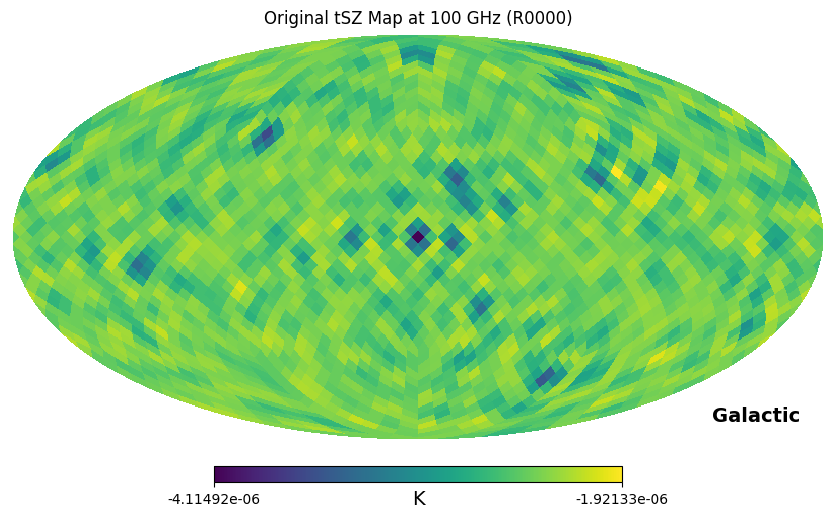

In [99]:
import os, time, hashlib
import numpy as np
from s2wav import synthesis, filters

# ---- your settings ----
component    = "tSZ"
freq_tag     = "F100"
realization  = "R0000"   # change to R0001 etc. if you regenerated
L_max        = 32
N_directions = 1
# -----------------------

filt = filters.filters_directional_vectorised(L_max, N_directions)

def file_info(p):
    """Print where we are loading from and basic file stats."""
    ap   = os.path.abspath(p)
    real = os.path.realpath(p)  # follows symlinks
    exists = os.path.exists(p)
    print(f"→ {p}")
    print(f"    abs:     {ap}")
    print(f"    real:    {real}")
    print(f"    exists:  {exists}")
    if exists:
        st = os.stat(p)
        print(f"    size:    {st.st_size:,} bytes")
        print(f"    mtime:   {time.ctime(st.st_mtime)}")
        try:
            # quick fingerprint (first 1 MB) so you can tell files apart
            with open(p, "rb") as fh:
                h = hashlib.md5(fh.read(1 << 20)).hexdigest()
            print(f"    md5(1MB): {h}")
        except Exception as e:
            print(f"    md5:     {e}")
    return real

print(f"\n[trace] component={component}, freq_tag={freq_tag}, realization={realization}\n")

# ---- scaling coeffs ----
scal_path = f"wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_{component}_{freq_tag}_{realization}.npy"
print("[Scaling coeffs]")
_ = file_info(scal_path)
f_scal = np.load(scal_path)

# ---- wavelet coeffs (scales 0..5 as in your code) ----
wavelet_coeffs = []
print("\n[Wavelet coeffs]")
for scale in range(6):
    wpath = f"wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_{component}_{freq_tag}_S{scale}_{realization}.npy"
    _ = file_info(wpath)
    wavelet_coeffs.append(np.real(np.load(wpath)))

# ---- synthesis ----
MW_Pix = synthesis(wavelet_coeffs, L=L_max, f_scal=f_scal, filters=filt, N=N_directions)
print("\n[Synthesis] MW_Pix shape:", MW_Pix.shape)

# Optional: visualize with your helper
title = f"Original {component} Map at 100 GHz ({realization})"
visualize_MW_Pix_map(MW_Pix, title)


(32, 63)


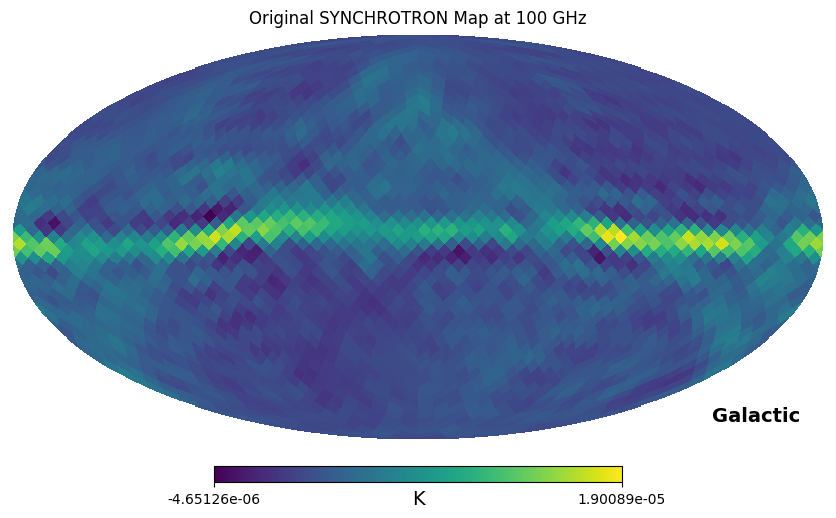

In [100]:
import numpy as np
from s2wav import synthesis, filters

L_max = 32
N_directions = 1
filt = filters.filters_directional_vectorised(L_max, N_directions)

f_scal = np.load("wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_Sync_F100_R0000.npy")
wavelet_coeffs = [
    np.real(np.load(f"wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_Sync_F100_S{scale}_R0000.npy"))
    for scale in range(6)
]

MW_Pix = synthesis(wavelet_coeffs, L=L_max, f_scal=f_scal, filters=filt, N=1)
print(MW_Pix.shape)
title = "Original SYNCHROTRON Map at 100 GHz"
visualize_MW_Pix_map(MW_Pix, title)


(32, 63)


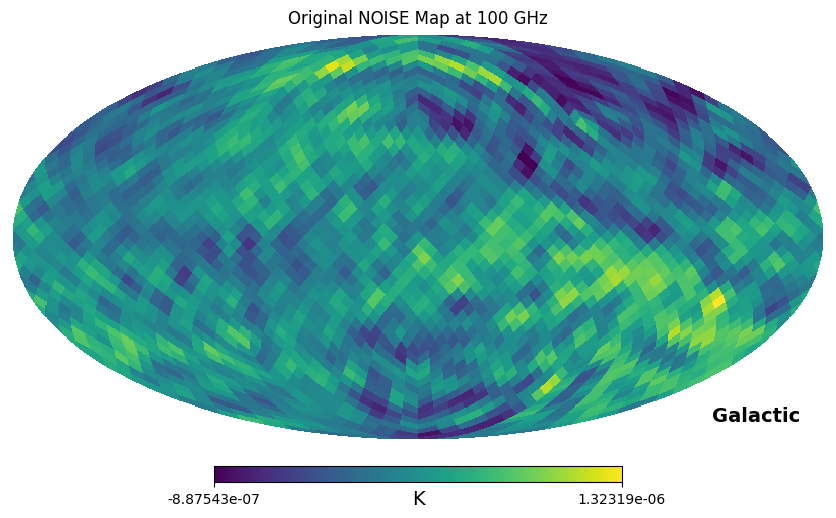

In [101]:
import numpy as np
from s2wav import synthesis, filters

L_max = 32
N_directions = 1
filt = filters.filters_directional_vectorised(L_max, N_directions)

f_scal = np.load("wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_Noise_F100_R0000.npy")
wavelet_coeffs = [
    np.real(np.load(f"wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_Noise_F100_S{scale}_R0000.npy"))
    for scale in range(6)
]

MW_Pix = synthesis(wavelet_coeffs, L=L_max, f_scal=f_scal, filters=filt, N=1)
print(MW_Pix.shape)
title = "Original NOISE Map at 100 GHz"
visualize_MW_Pix_map(MW_Pix, title)


(32, 63)


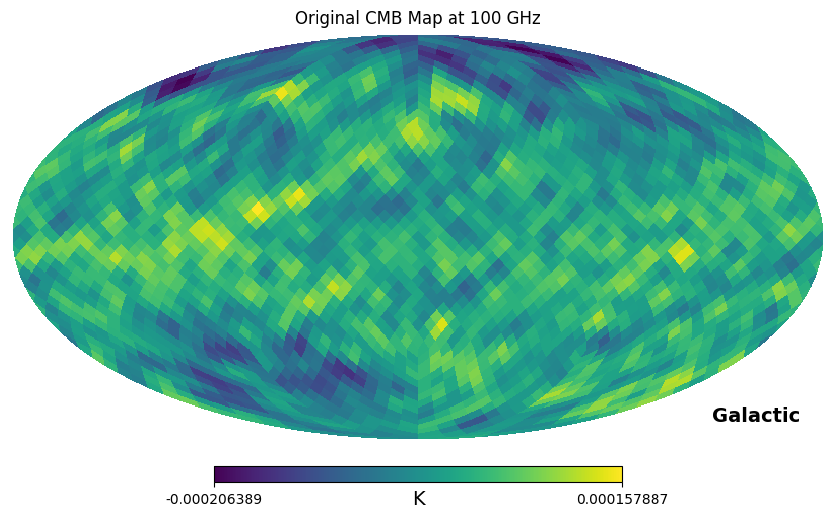

In [102]:
import numpy as np
from s2wav import synthesis, filters

component = "CMB"  

L_max = 32
N_directions = 1
filt = filters.filters_directional_vectorised(L_max, N_directions)

# Load scaling coefficients
f_scal = np.load(f"wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_{component}_F100_R0000.npy")

# Load wavelet coefficients for all scales
wavelet_coeffs = [
    np.real(np.load(f"wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_{component}_F100_S{scale}_R0000.npy"))
    for scale in range(6)
]

# Synthesis
MW_Pix = synthesis(wavelet_coeffs, L=L_max, f_scal=f_scal, filters=filt, N=1)
print(MW_Pix.shape)

title = f"Original {component} Map at 100 GHz"
visualize_MW_Pix_map(MW_Pix, title)


(32, 63)


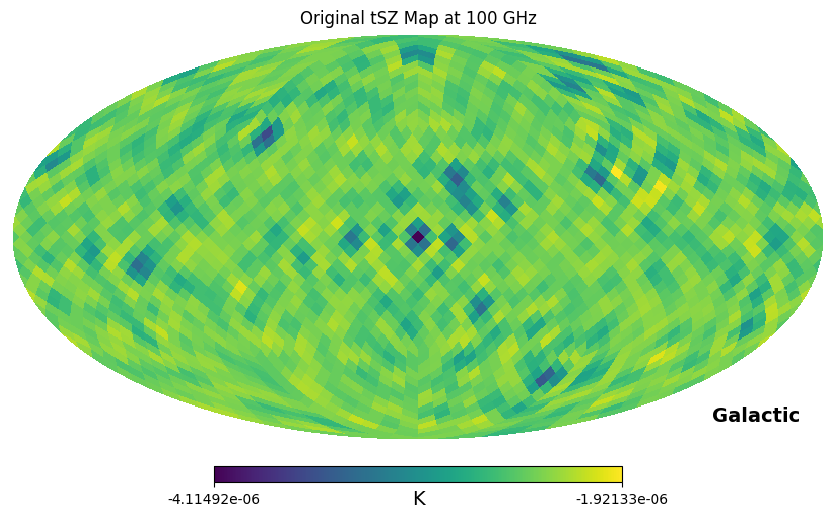

In [103]:
import numpy as np
from s2wav import synthesis, filters

component = "tSZ"  

L_max = 32
N_directions = 1
filt = filters.filters_directional_vectorised(L_max, N_directions)

# Load scaling coefficients
f_scal = np.load(f"wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_{component}_F100_R0000.npy")

# Load wavelet coefficients for all scales
wavelet_coeffs = [
    np.real(np.load(f"wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_{component}_F100_S{scale}_R0000.npy"))
    for scale in range(6)
]

# Synthesis
MW_Pix = synthesis(wavelet_coeffs, L=L_max, f_scal=f_scal, filters=filt, N=1)
print(MW_Pix.shape)

title = f"Original {component} Map at 100 GHz"
visualize_MW_Pix_map(MW_Pix, title)


(32, 63)


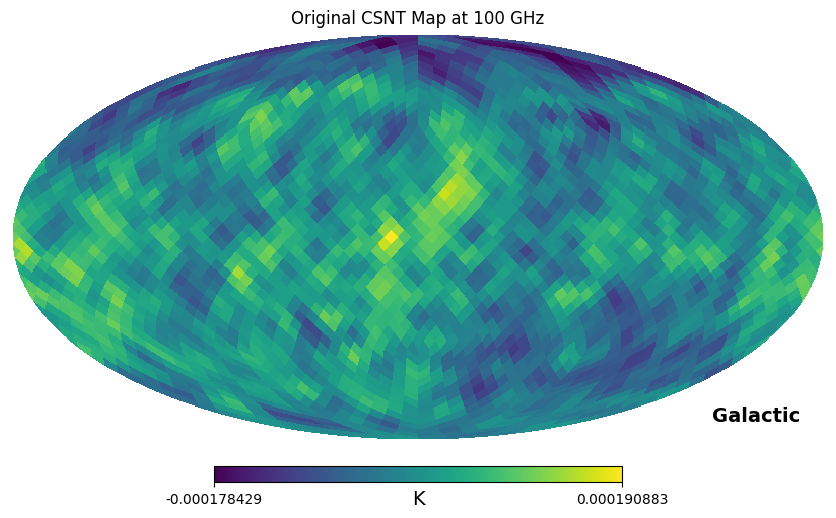

In [104]:
import numpy as np
from s2wav import synthesis, filters

component = "CSNT"  

L_max = 32
N_directions = 1
filt = filters.filters_directional_vectorised(L_max, N_directions)

# Load scaling coefficients
f_scal = np.load(f"wavelet_transform/wavelets/scal_coeffs/Scal_MW_Pix_{component}_F100_R0000.npy")

# Load wavelet coefficients for all scales
wavelet_coeffs = [
    np.real(np.load(f"wavelet_transform/wavelets/wav_MW_maps/Wav_MW_Pix_{component}_F100_S{scale}_R0000.npy"))
    for scale in range(6)
]

# Synthesis
MW_Pix = synthesis(wavelet_coeffs, L=L_max, f_scal=f_scal, filters=filt, N=1)
print(MW_Pix.shape)

title = f"Original {component} Map at 100 GHz"
visualize_MW_Pix_map(MW_Pix, title)


In [105]:
# Display the original map
# import healpy as hp
# frequencies = ["030", "044", "070", "100", "143", "217", "353", "545", "857"]
# CSN_data_path_template = 'CMB_total/CSN_HP_Map_F{frequency}_L{L_max}_R{realization}.fits'

# for i in range(len(frequencies)):
#     hp.mollview(hp.read_map(CSN_data_path_template.format(frequency=frequencies[i], L_max = 2048, realization='0000')))

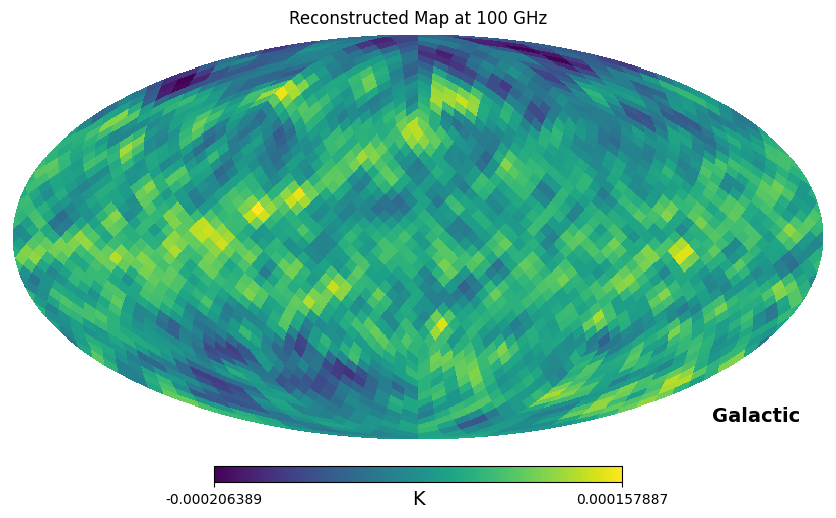

In [106]:
from s2wav import filters, synthesis
import numpy as np
import s2wav

# --- Parameters ---
L_max = 32
N_directions = 1
frequency = '100'       # change to e.g. '030', '044', ...
realization = '0000'
scales = range(6)

# --- File templates ---
file_template = (
    "wavelet_transform/wavelets/wav_MW_maps/"
    "Wav_MW_Pix_F{frequency}_S{scale}_R{realization}.npy"
)
f_scal_template = (
    "wavelet_transform/wavelets/scal_coeffs/"
    "Scal_MW_Pix_F{frequency}_R{realization}.npy"
)

# --- Load filters ---
filt = filters.filters_directional_vectorised(L_max, N_directions)

# --- Load scaling coefficients ---
f_scal = np.load(f_scal_template.format(frequency=frequency, realization=realization))

# --- Load wavelet coefficients ---
wavelet_coeffs = [
    np.real(np.load(file_template.format(frequency=frequency, scale=scale, realization=realization)))
    for scale in scales
]

# --- Synthesize from wavelet space back to pixel space ---
MW_Pix = synthesis(wavelet_coeffs, L=L_max, f_scal=f_scal, filters=filt, N=N_directions)

# --- Visualize ---
title = f"Reconstructed Map at {frequency} GHz"
visualize_MW_Pix_map(MW_Pix, title)
